# NOS database about Italy - experimenting with topic and sentiment analysis

Max Scheijen published an excellent database with over 230.000 news articles published by the Dutch national brodacasting company NOS. Without doubt this is a gold mine to find valuable information over various topics.
My professonial interest is in Dutch-Italian relations. Therefore, I used this dataset to do some specific analysis about Italy through Dutch eyes. I am particularly interested in the topics used over the last 10 years and I was wondering whether it would be possible to analyse to some extent the sentiment (in specific polarity) in these articles. To perform these analysis, we will use some parts of the notebook of Max Scheijen, but also Top2Vec and TextBlob.

First we will start importing the necessary libraries and dataset.


In [1]:

import spacy
import unicodedata
import re

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import textstat
import operator

from matplotlib.ticker import PercentFormatter
from top2vec import Top2Vec

from textblob import TextBlob
from textblob_nl import PatternAnalyzer

# set language to dutch 
textstat.set_lang("nl")

# better quality plots
%config InlineBackend.figure_format = "retina"

# Title font size
TITLE_SIZE = 14

# turn off warnings
import warnings
warnings.simplefilter(action='ignore')

In [2]:
# Get data
nos_df = (pd.read_csv("dutch-news-articles.csv",
                      parse_dates=["datetime"], encoding="utf-8") 
          # sort values by date published
          .sort_values("datetime")
          )
# Convert category colum to category
nos_df.category = pd.Categorical(nos_df.category)

# Display first three rows
nos_df.head(3)

,datetime,title,content,category,url
0,2010-01-01 00:49:00,Enige Litouwse kerncentrale dicht,De enige kerncentrale van Litouwen is oudjaars...,Buitenland,https://nos.nl/artikel/126231-enige-litouwse-k...
1,2010-01-01 02:08:00,Spanje eerste EU-voorzitter onder nieuw verdrag,Spanje is met ingang van vandaag voorzitter va...,Buitenland,https://nos.nl/artikel/126230-spanje-eerste-eu...
2,2010-01-01 02:09:00,Fout justitie in Blackwater-zaak,Vijf werknemers van het omstreden Amerikaanse ...,Buitenland,https://nos.nl/artikel/126233-fout-justitie-in...


How many news articles have been published by the NOS?

In [3]:
len(nos_df)

230912

And how many articles in specfic mentioning Italy ("Italië" in Dutch)?

In [4]:
df_italy = nos_df[nos_df['content'].str.contains("Italië")]
len(df_italy)

4553

Let's present this in a pie chart, indicating what percentage of the articles is mentioning "Italië"

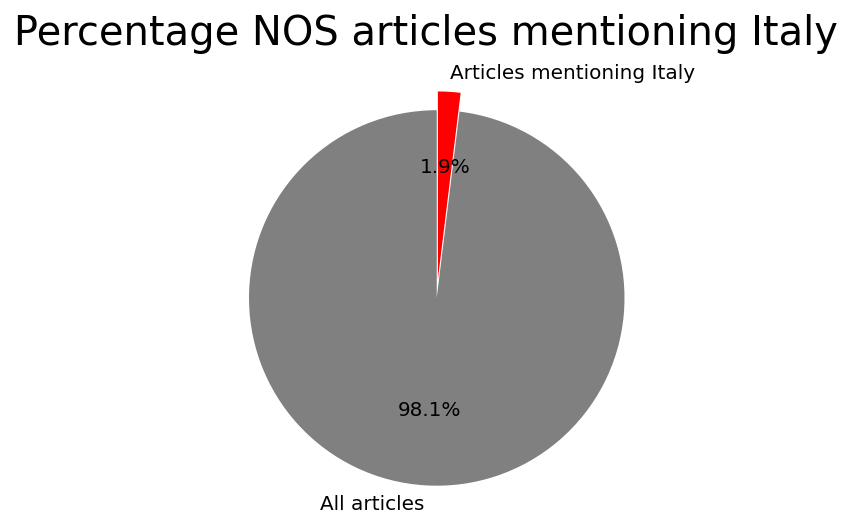

In [5]:
labels = 'All articles', 'Articles mentioning Italy'
sizes = [len(nos_df), len(df_italy)]
explode = (0, 0.1)  #  "explodes" the 2nd slice (i.e. 'Italy')
colours = {'All articles': 'grey',
           'Articles mentioning Italy': 'red'}
plt.suptitle('Percentage NOS articles mentioning Italy', fontsize=20)
plt.pie(sizes, explode=explode, colors=[colours[key] for key in labels], labels=labels, 
            autopct='%1.1f%%', startangle=90)
plt.axis('equal')  
plt.show()

Now find how important is Italy in the Dutch news in respect to the other EU member states (The Netherlands not included)?

In [6]:

EU = ('België', 'Bulgarije', 'Cyprus', 'Denemarken', 'Duitsland', 
      'Estland',  'Finland', 'Frankrijk', 'Griekenland', 'Hongarije', 
      'Ierland', 'Italië', 'Kroatië', 'Letland', 'Litouwen', 
      'Luxemburg', 'Malta', 'Oostenrijk', 'Polen', 
      'Portugal', 'Roemenië', 'Slovenië', 'Slowakije', 'Spanje', 'Tsjechië', 'Zweden')
# all EU countries except for the Netherlands and former member UK

countCountryArticles = {}

for country in EU:
    thisCountry = nos_df[nos_df['content'].str.contains(country)]
    countCountryArticles[country] = (len(thisCountry))
sortedArtCountries = dict( sorted(countCountryArticles.items(), key=operator.itemgetter(1),reverse=True))
print(sortedArtCountries)


{'Duitsland': 11385, 'Frankrijk': 8524, 'België': 6099, 'Italië': 4553, 'Spanje': 3975, 'Griekenland': 3631, 'Polen': 2227, 'Oostenrijk': 2207, 'Zweden': 1686, 'Ierland': 1528, 'Denemarken': 1229, 'Portugal': 1086, 'Hongarije': 1071, 'Luxemburg': 1052, 'Roemenië': 758, 'Tsjechië': 593, 'Bulgarije': 568, 'Finland': 562, 'Cyprus': 555, 'Kroatië': 465, 'Malta': 460, 'Litouwen': 432, 'Slowakije': 407, 'Estland': 335, 'Slovenië': 304, 'Letland': 279}


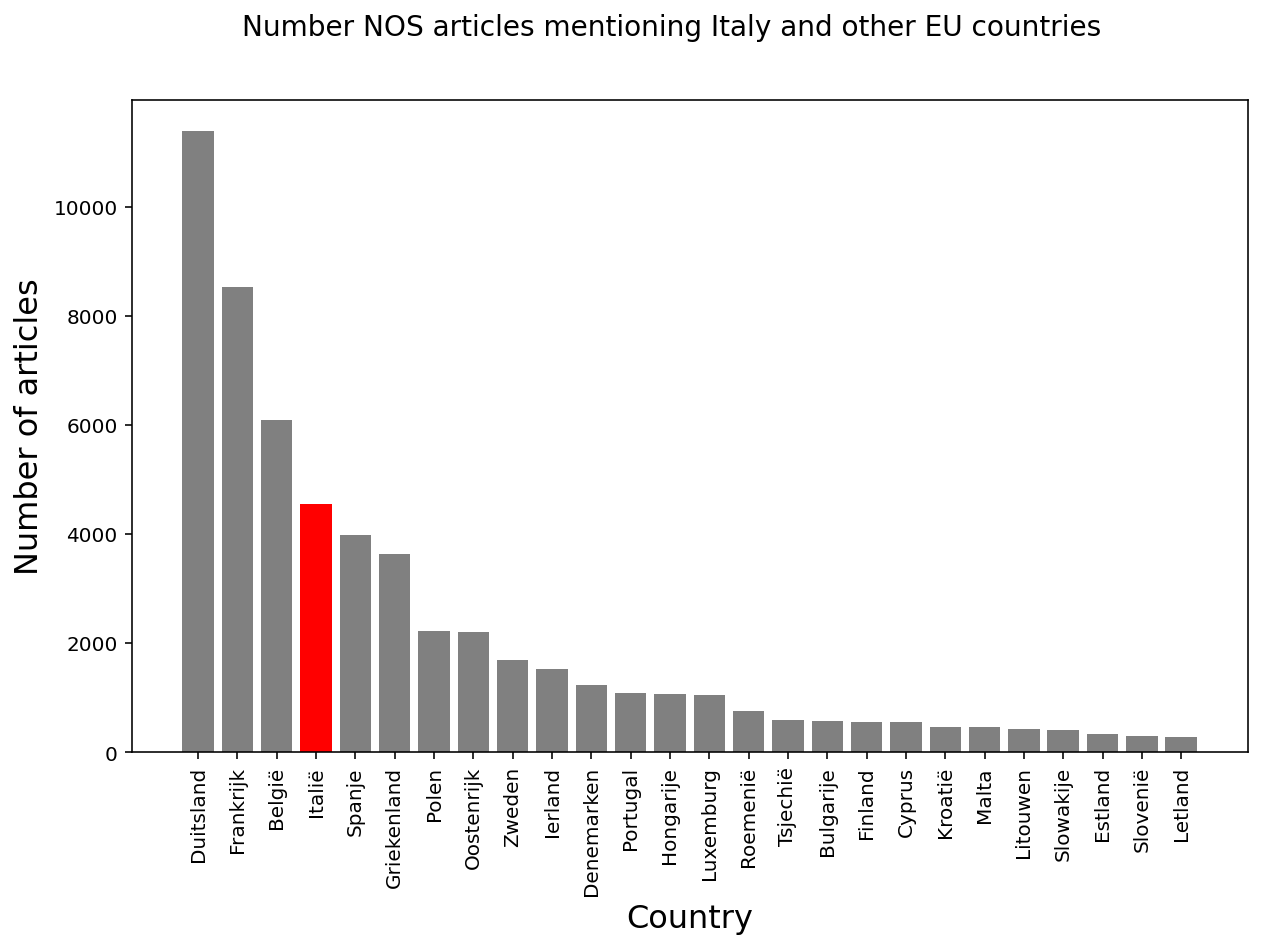

In [7]:
# Number NOS articles mentioning Italy and other EU countries
plt.figure(figsize=(10,6))
ind = np.arange(len(sortedArtCountries))
palette = ['red' if x == 'Italië' else 'grey' for x in sortedArtCountries.keys() ]
plt.bar(ind, list(sortedArtCountries.values()), color=palette)
plt.xticks(ind, list(sortedArtCountries.keys()), rotation=90)
plt.suptitle('Number NOS articles mentioning Italy and other EU countries', fontsize=TITLE_SIZE)
plt.xlabel('Country', fontsize=16)
plt.ylabel('Number of articles', fontsize=16)
plt.show()

Now we will look at the amount of articles mentioning Italy per year and month. The various crises are clearly visible, for example the immigration situation in the Mediterranean Sea in 2018 and the negotations in the Summer of 2020 about the EU recovery fund lead to clearly visible spikes in the graph.

In [8]:
# Function that groups times series
# I used the code provide by Max Scheijen, but used only the absolute count
# https://www.kaggle.com/maxscheijen/text-mining-dutch-news-articles

def group_timeseries(df, column, normalize=False, count=False):
    # Group by year and month and select colimn
    group = df.groupby([df.datetime.dt.year, df.datetime.dt.month])[column]

    # Value count and unstack to dataframe
    if count:
        df = group.value_counts(normalize=normalize).unstack()

    # Count 
    else:
        df = group.count()

    # Select year and month index
    years = pd.Series(df.index.get_level_values(level=0).values.astype(str))
    months = pd.Series(df.index.get_level_values(level=1).values.astype(str))

    # Combine year and month to new date
    dates = pd.to_datetime(years + "-" + months)

    # Set date as index
    df = df.reset_index(drop=True)
    df.index = dates

    return df

# Overall absolute count over articles
all_overtime = group_timeseries(df_italy, "category", count=False)

# Get absolute and normalized grouped time series
cat_timeseries_absolute = group_timeseries(df_italy, "category", count=True)
# cat_timeseries_normalized = group_timeseries(df_italy, "category", normalize=True, count=True)

Text(0.5, 0, 'Year')

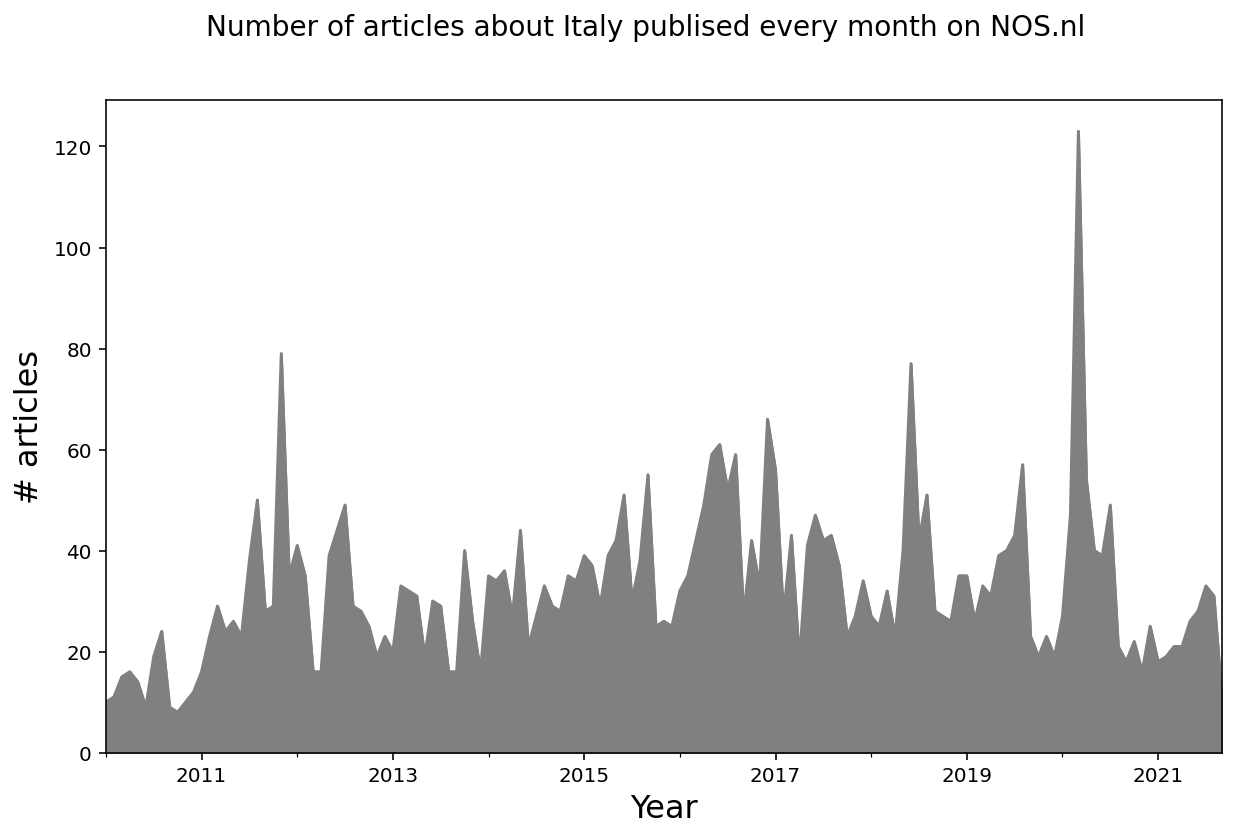

In [9]:
# Intialize figure
plt.subplots(figsize=(10, 6))

# Plot absolute number of acticles over time
all_overtime.plot(kind="area", color="grey")
plt.suptitle("Number of articles about Italy publised every month on NOS.nl", fontsize=TITLE_SIZE)
plt.ylabel("# articles", fontsize=16)
plt.xlabel('Year', fontsize=16)



In the NOS database articles are based on categories, like domestic and international news. Using  Max Scheijen's code it is interesting to see that in the Summer 2020 when Europe was dsicussing the recovery plan, Italy was mentioned more in Dutch domestic news than internatioal articles. 

Text(0, 0.5, '# articles')

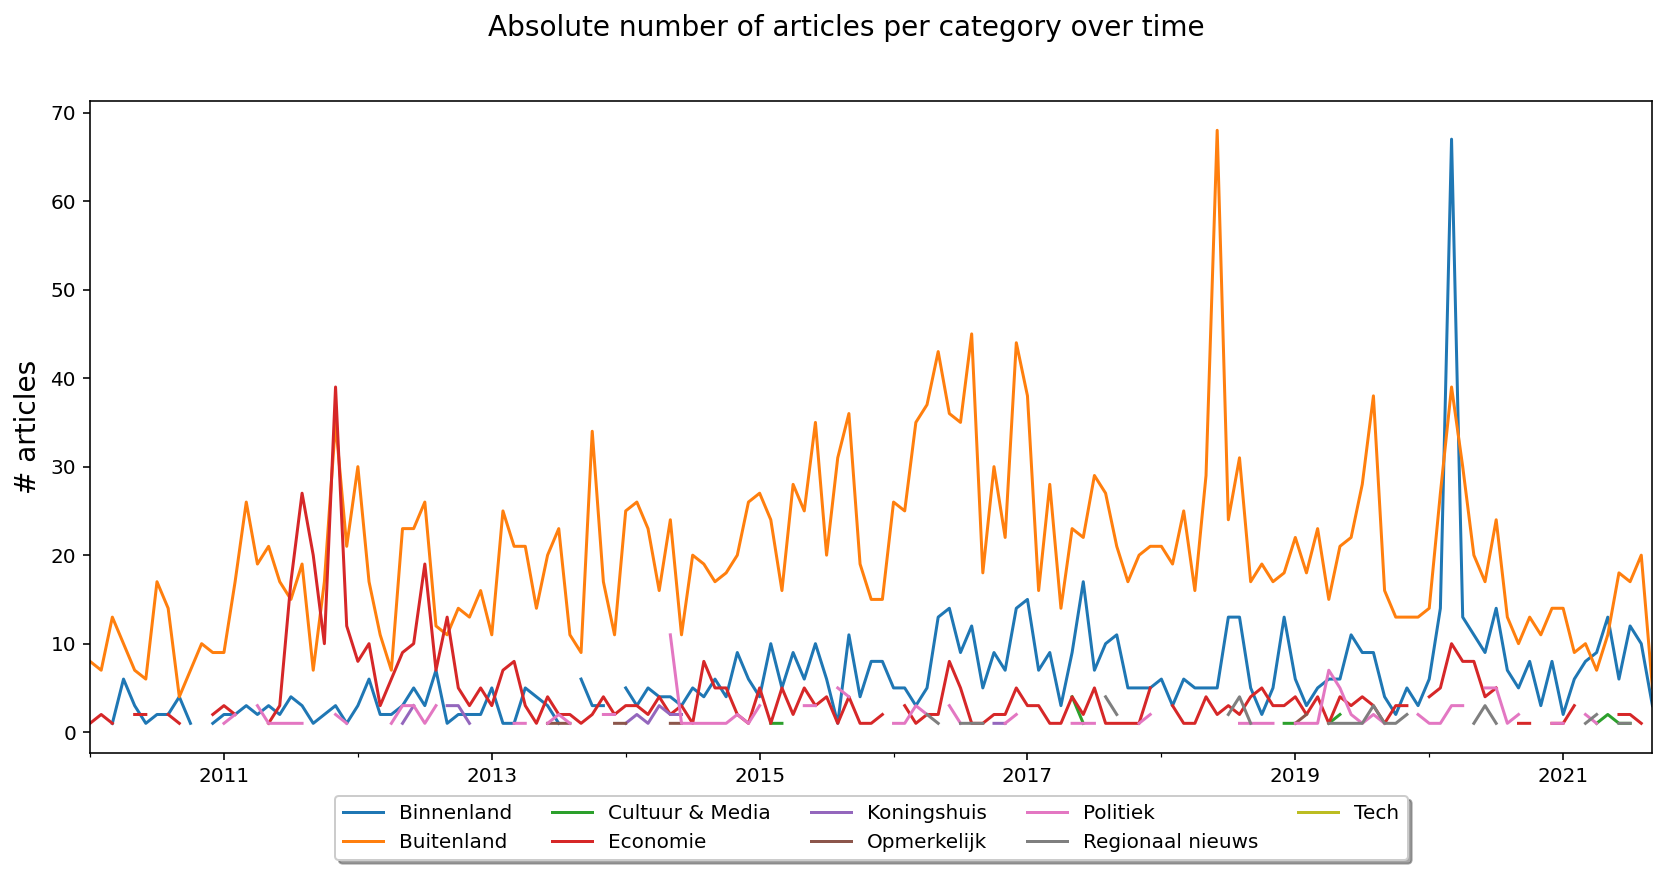

In [10]:
# Figure 1: Absolute number of acticles per category
group_timeseries(df_italy, "category", count=True).plot(figsize=(14, 6))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.suptitle("Absolute number of articles per category over time", fontsize=TITLE_SIZE)
plt.ylabel("# articles", fontsize=TITLE_SIZE)




Now that we have seen the trends over time, what can we find out about the topics and sentiment?
We will use Spacy to eliminate stopwords, Top2Vec to analyse the topics and Textblob for sentiment analysis.

In [11]:
import spacy
nlp = spacy.load('nl_core_news_sm')
all_stopwords = nlp.Defaults.stop_words


In [12]:
df_italy['content'] = df_italy['content'].apply(lambda x: ' '.join([item for item in x.split() if item.lower() not in all_stopwords]))



Let's do some sentiment analysis with this dataset. First let's have a look at the overall polarity and subjectivity.

In [13]:
# Extract sentiment
# df_italy["sentiment"] = df_italy.lemmatizer.apply(lambda x: tuple(TextBlob(x.text, analyzer=PatternAnalyzer()).sentiment))
df_italy["sentiment"] = df_italy.content.apply(lambda x: tuple(TextBlob(x, analyzer=PatternAnalyzer()).sentiment))

# Get polarity from tuple 
df_italy["polarity"] = df_italy["sentiment"].str.get(0)

# Get subjectivity from tuple 
df_italy["subjectivity"] = df_italy["sentiment"].str.get(1)

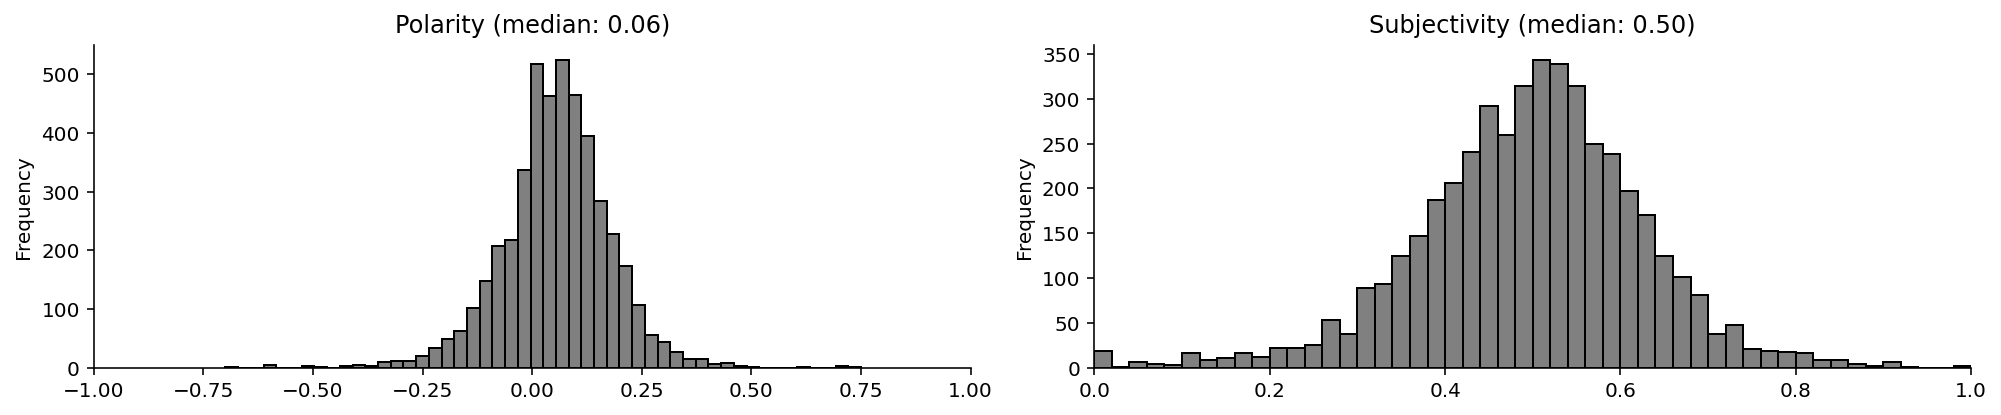

In [14]:
# Initialze figure
fig, ax = plt.subplots(figsize=(14, 3), ncols=2)

# Plot polarity
df_italy["polarity"].plot(kind="hist", bins=50, edgecolor="k", color="gray", ax=ax[0], title=f"Polarity (median: {df_italy.polarity.median():.2f})")

# Plot subjectivity
df_italy["subjectivity"].plot(kind="hist", bins=50, edgecolor="k", color="gray", ax=ax[1], title=f"Subjectivity (median: {df_italy.subjectivity.median():.2f})")

# Limits
ax[0].set_xlim(-1, 1)
ax[1].set_xlim(0, 1)

# Meta-data plot
fig.tight_layout()
sns.despine()

We can also plot the variations in polarity in the articles over time. However, the result is not very meaningful. Probably the differences are based on variety of topics that result in the NOS database.

<AxesSubplot:xlabel='datetime,datetime', ylabel='Polarity score'>

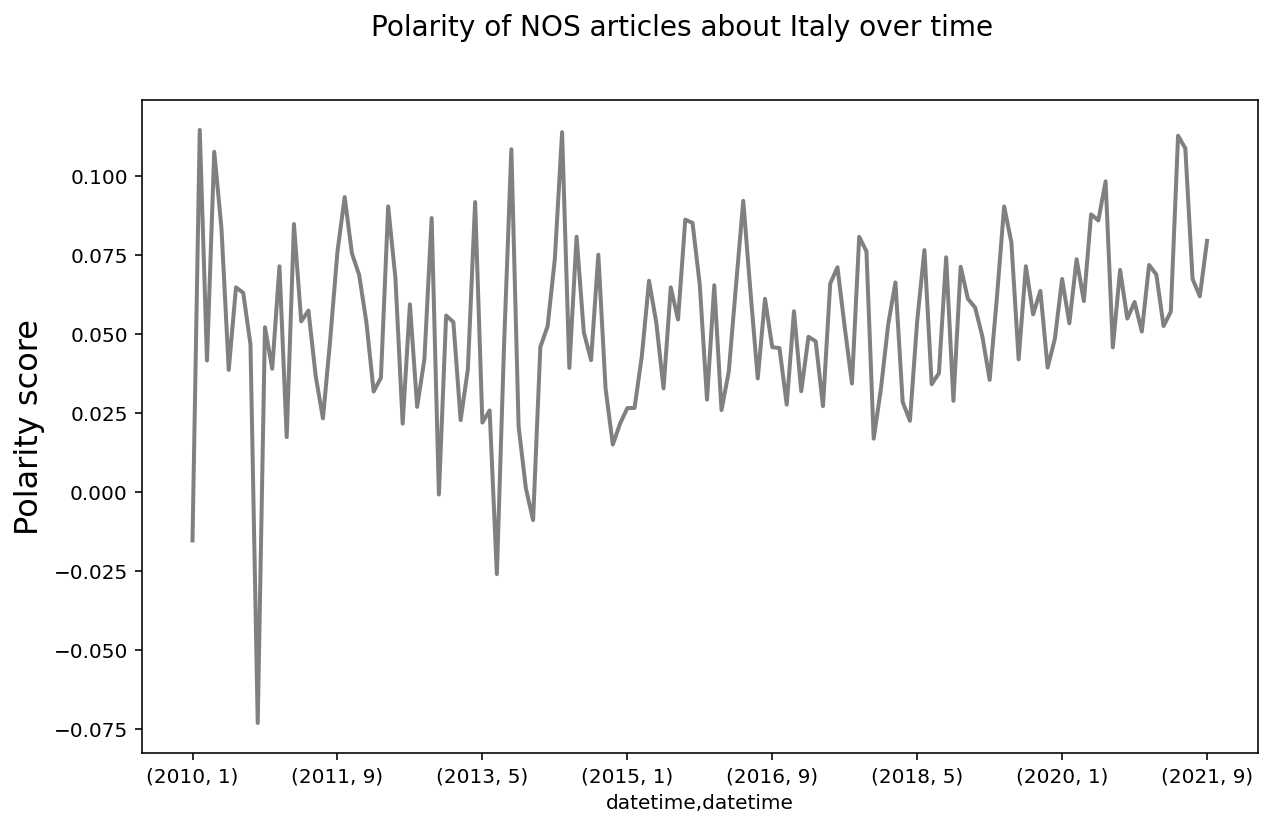

In [15]:
df_pol = df_italy.groupby([df_italy.datetime.dt.year, df_italy.datetime.dt.month])["polarity"].mean()
plt.subplots(figsize=(10, 6))
plt.suptitle("Polarity of NOS articles about Italy over time", fontsize=TITLE_SIZE)
plt.ylabel("Polarity score", fontsize=16)
plt.xlabel(df_italy.groupby([df_italy.datetime.dt.year]))
df_pol.plot(linewidth=2, color='grey')


To get some more meaningful results, it would be nice to see whether there are differences in polarity among the various topics that were mentioned in the articles. To do this, we will use Top2Vec to extract the topics from the database.

In [16]:
from top2vec import Top2Vec
italy = df_italy['content'].tolist()
model = Top2Vec(documents=italy, speed="learn", workers=8)

2021-11-03 22:45:17,744 - top2vec - INFO - Pre-processing documents for training
2021-11-03 22:45:19,102 - top2vec - INFO - Creating joint document/word embedding
2021-11-03 22:45:53,506 - top2vec - INFO - Creating lower dimension embedding of documents
2021-11-03 22:46:10,407 - top2vec - INFO - Finding dense areas of documents
2021-11-03 22:46:10,500 - top2vec - INFO - Finding topics


How many topics did Top2Vec find in the dataset?

In [17]:
numTopics=model.get_num_topics()
print(numTopics)

58


We can show the number of articles per topic.

In [18]:
topic_sizes, topic_nums = model.get_topic_sizes()
topic_words, word_scores, topic_nums = model.get_topics(numTopics)
print(topic_sizes)

[253 239 217 186 182 177 136 128 123 118 106 103  99  93  92  91  90  86
  84  84  83  81  79  78  77  75  70  68  61  61  59  58  58  55  54  53
  51  50  50  47  45  44  41  39  38  36  36  36  36  35  31  28  27  26
  26  25  25  24]


We will make a new dataframe to perform the sentiment analysis. The topic number will be the index and we add a columnn with the topic words. Let's have a look at the first 5 topics. 
Top2Vec seems to do a very decent job. Most articles were written about the pandemic, elections and maffia related drugs traffic, immigrants in the Mediterranean and the case of Amanda Knox.

In [19]:
df_topics = pd.DataFrame()
df_topics['topic_nums'] = topic_nums
df_topics['topic_words'] = [word for word in topic_words]
df_topics.set_index('topic_nums', inplace=True)
print(df_topics.head())



                                                  topic_words
topic_nums                                                   
0           [militaire, kadhafi, arabische, opstandelingen...
1           [verkiezingen, silvio, pd, coalitie, grillo, l...
2           [drugshandel, opgepakt, ndrangheta, maffia, co...
3           [herverdeling, eu, afspraken, vluchtelingen, a...
4           [kustwacht, verdronken, kust, zee, boot, opgep...


Now we will add a column with a list of all the articles related to each topic.

In [20]:
listOfArticles =[]
for i in range(numTopics):
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=i, num_docs=topic_sizes[i])
    listOfArticles.append(documents)
    
# df_topics['articles'] = [doc for doc in listOfArticles]
df_topics['articles'] = listOfArticles
print(df_topics.head(10))
    

                                                  topic_words  \
topic_nums                                                      
0           [militaire, kadhafi, arabische, opstandelingen...   
1           [verkiezingen, silvio, pd, coalitie, grillo, l...   
2           [drugshandel, opgepakt, ndrangheta, maffia, co...   
3           [herverdeling, eu, afspraken, vluchtelingen, a...   
4           [kustwacht, verdronken, kust, zee, boot, opgep...   
5           [veroordeeld, cel, rechtbank, straf, rechter, ...   
6           [rente, ecb, schuldpapier, staatsleningen, opk...   
7           [noodfonds, eurolanden, fonds, esm, eurozone, ...   
8           [schip, sea, schepen, hulporganisatie, watch, ...   
9           [producten, winkel, consumenten, klanten, amaz...   

                                                     articles  
topic_nums                                                     
0           [Amerikaanse minister Buitenlandse Zaken John ...  
1           [Italiaanse pol

We now will now analyse the sentiment of the articles using TextBlob.


In [21]:
df_topics["sentiment"] = df_topics.articles.apply(lambda x: tuple(TextBlob(' '.join(x), analyzer=PatternAnalyzer()).sentiment))
# Get polarity from tuple 
df_topics["polarity"] = df_topics["sentiment"].str.get(0)
# Get subjectivity from tuple 
df_topics["subjectivity"] = df_topics["sentiment"].str.get(1)

Now we will summerise the topics in a graph confronting the polarity of the topics. The differences between the topics are not huge. In fact, the range is relatively small (from approximately -0.025 to 0.15). However, there are some interesting differences. Articles about the Eurovision Songfestival and Pompei seem to have a more positive polarity than articles about demonstrations and immigrants. 
For the readability of the Y- axis I had to reduce the number of words to the first one. It would have been probably better to infer a more suitable keyword for each topic. 


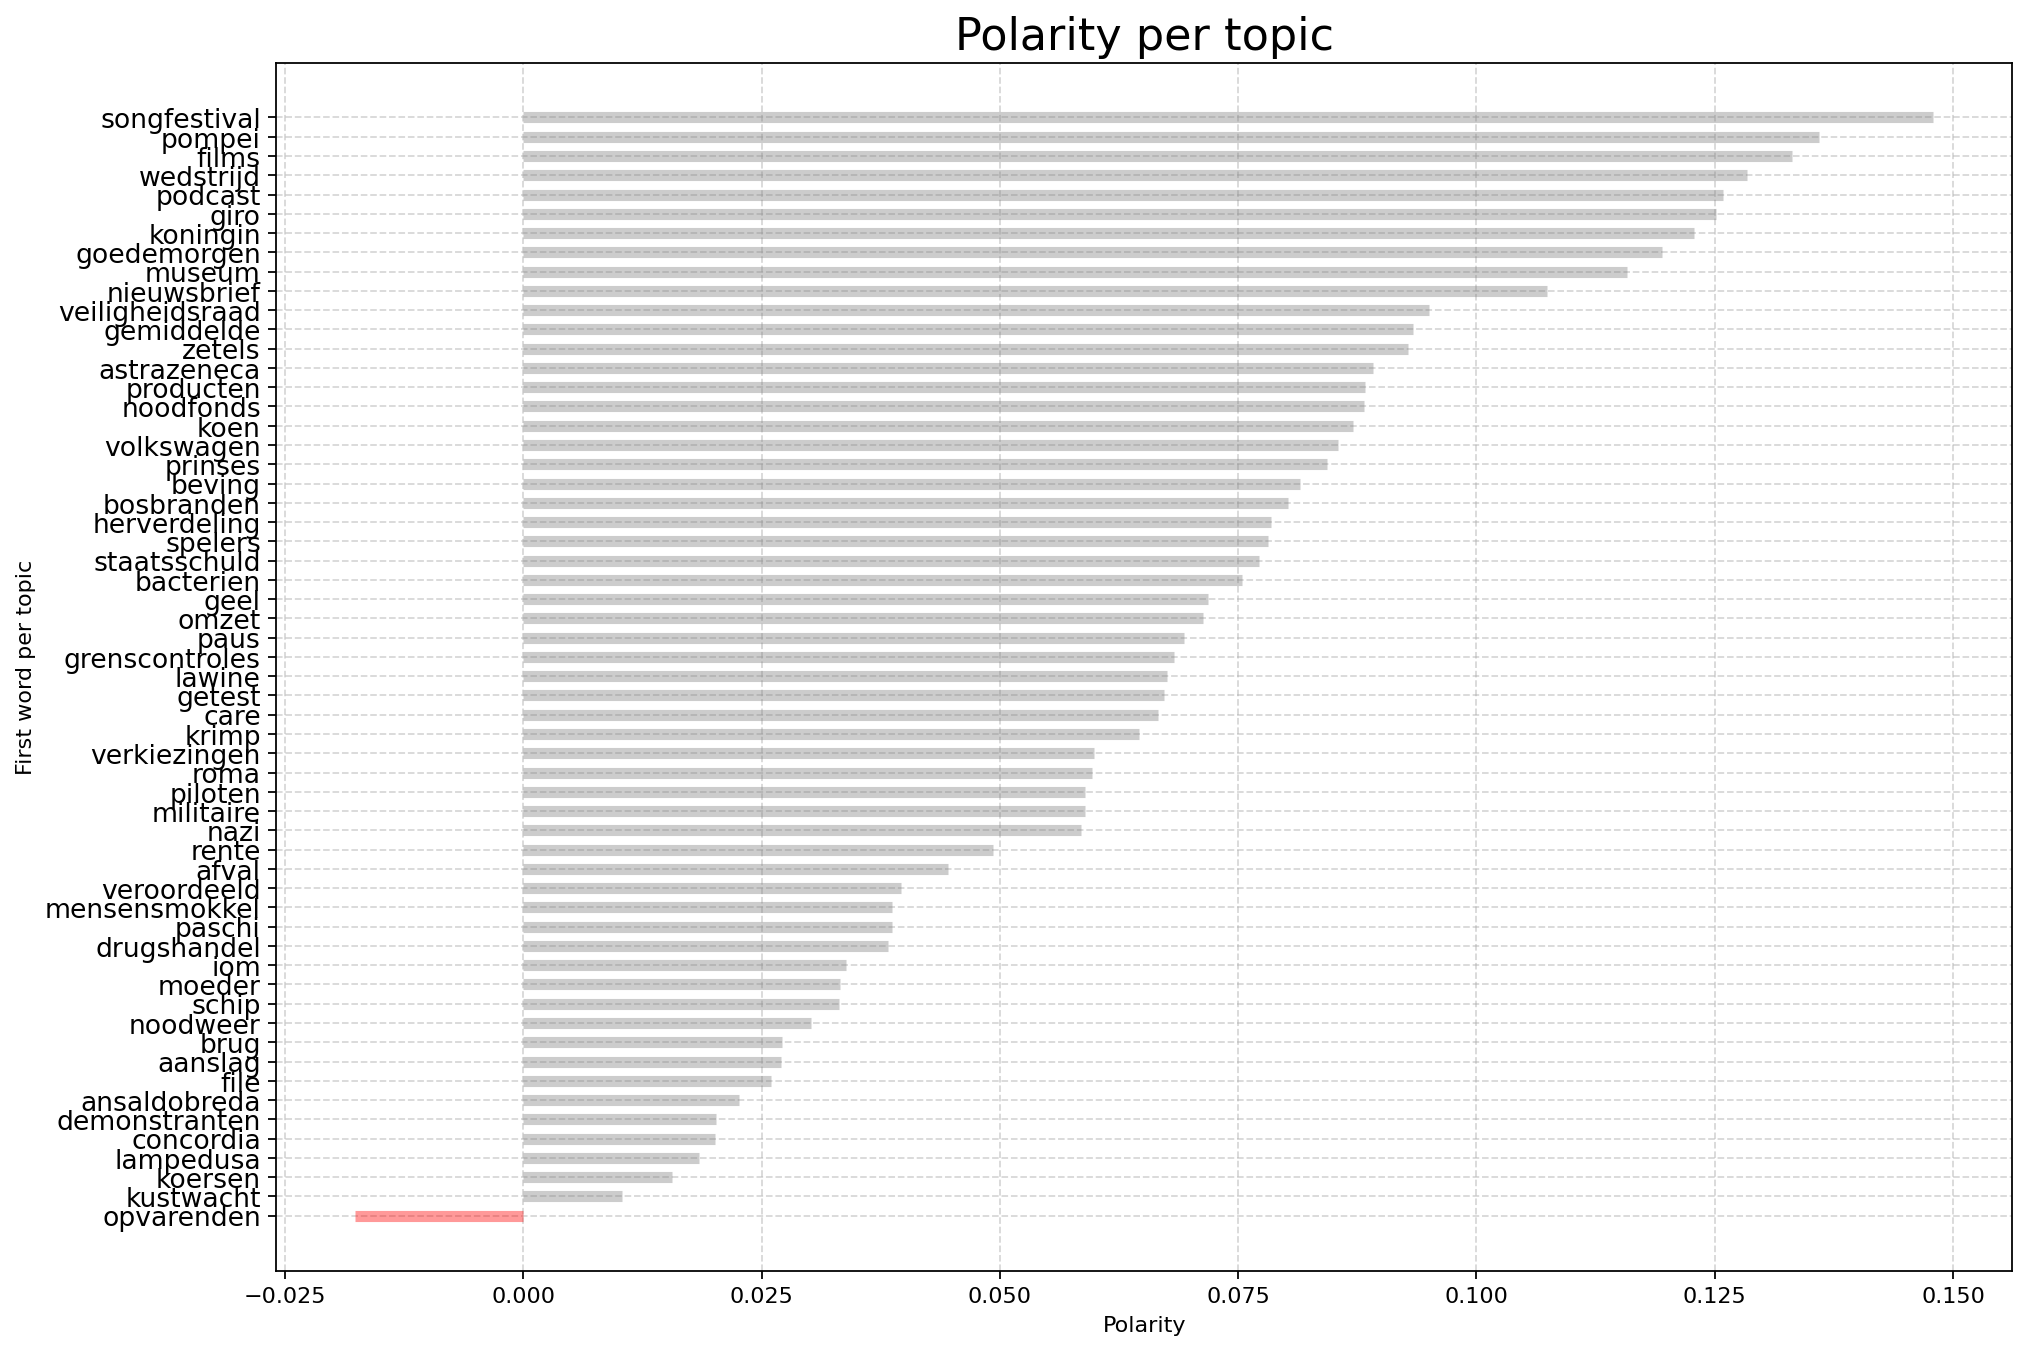

In [22]:
# Prepare Data
df = df_topics[['polarity', 'topic_words']]
df.topic_words = df.topic_words.str[0]
for i in range(35):
    df['colors'] = ['red' if float(x) < 0 else 'grey' for x in df['polarity']]
    
# Sort values from lowest to highest
df.sort_values('polarity', inplace=True)
  
# Resets initial index in Dataframe to None
df.reset_index(inplace=True)
  
# Draw plot
plt.figure(figsize=(14, 10), dpi=80)

# Plotting the horizontal lines
plt.hlines(y=df.index, xmin=0, xmax=df.polarity,
           color=df.colors, alpha=0.4, linewidth=5)

# Setting the labels of x-axis and y-axis
plt.gca().set(ylabel='First word per topic', xlabel='Polarity')
  
# Setting Date to y-axis
# plt.yticks(df.index, df.articles, fontsize=12)
plt.yticks(df.index, df.topic_words, fontsize=12)
# plt.yticks(df.index, fontsize=12)
  
# Title of Bar Chart
plt.title('Polarity per topic', fontdict={
          'size': 20})
  
# Optional grid layout
plt.grid(linestyle='--', alpha=0.5)
  
# Displaying the Diverging Bar Chart
plt.show()


Finally, let's have a look at the articles with the highest polarity (an article about a new NOS podcast) and the lowest polarity (people losing jobs at TNT Express).

In [23]:
df_italy.sort_values(by=['polarity']).head(1)

,datetime,title,content,category,url,sentiment,polarity,subjectivity
61384,2013-06-10 13:35:00,Ontslagen bij TNT Express in Italië,Pakketjesbezorger TNT Express gaat Italiaanse ...,Economie,https://nos.nl/artikel/516326-ontslagen-bij-tn...,"(-0.7, 0.9)",-0.7,0.9


In [24]:
nos_df.content.iloc[61384]

"Pakketjesbezorger TNT Express gaat de Italiaanse tak van het bedrijf reorganiseren. Daarbij verdwijnen 850 banen. TNT Express zegt dat de maatregelen nodig zijn vanwege de slechte economische situatie in het land. TNT gaat zo'n twintig kleinere distributiecentra sluiten om een aantal grotere over te houden. Volgens het bedrijf kunnen klanten na de reorganisatie op dezelfde dienstverlening rekenen. Er werken nu nog zo'n 3.000 mensen bij TNT in Italië. In 2011 kwam naar buiten dat volgens de Italiaanse justitie vestigingen van TNT Express in Noord-Italië in handen waren van de maffia. De vestigingen zijn toen onder toezicht gesteld. Volgens de autoriteiten was de Calabrische misdaadorganisatie 'Ndrangheta geïnfiltreerd in de TNT-bedrijven."

In [25]:
df_italy.sort_values(by=['polarity']).tail(1)

,datetime,title,content,category,url,sentiment,polarity,subjectivity
38141,2012-05-26 13:55:00,Podcast NOS Buitenland,Beluister podcast Buitenlandredactie NOS Nieuw...,Buitenland,https://nos.nl/artikel/377092-podcast-nos-buit...,"(0.75, 0.85)",0.75,0.85


In [26]:
nos_df.content.iloc[38141]

'Beluister de podcast van de Buitenlandredactie van NOS Nieuws, met de belangrijkste, mooiste en interessantste radioreportages uit het buitenland van de afgelopen week. De podcast is aan de rechterkant van deze pagina te beluisteren en ook te downloaden via de feed en iTunes. Deze week deden NOS-correspondenten verslag over deze onderwerpen: Meer Indonesiërs eisen genoegdoening Nederlandse oorlogsmisdadenInwoners Noord-Italië verbijsterd door schade aardbevingBlije Duitsers na overwinning Bayern München op OranjeAmerikaanse oorlogs-invaliden over AfghanistanVerkiezingscampagne Egypte vrolijke chaos '

In this notebook I tried out a few possibilities. Certainly, it could be done better, but I was able to show that  Python offers powerful tools to analyse texts. Top2Vex is able to extract meaningful topics. Using TextBlob it is possible to do some simple analysis which topics are more positive than others. Nevertheless, the usefullness of sentiment analysis is somewhat limited as it is of course not able to fully grasp the meaning of the texts (which is become clear when examining scores of various posts).